In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/energy-design-a/energy_design_a.csv
/kaggle/input/energy-design-b/energy_design_b.csv


In [2]:
# Import required libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind
from statsmodels.sandbox.stats.multicomp import multipletests

# Load datasets
energy_design_a = pd.read_csv("/kaggle/input/energy-design-a/energy_design_a.csv")
energy_design_b = pd.read_csv("/kaggle/input/energy-design-b/energy_design_b.csv")

In [3]:
# identifying the experimental design
energy_design_a.head()

,Fuel_Source,Building_Type,Energy_Usage
0,Natural_Gas,Residential,576.997736
1,Biofuel,Commercial,626.838952
2,Natural_Gas,Commercial,542.448624
3,Natural_Gas,Residential,594.053558
4,Natural_Gas,Commercial,413.235891


In [4]:
energy_design_b.head()

,Geographical_Region,Fuel_Source,CO2_Emissions
0,North,Natural_Gas,11.490142
1,North,Natural_Gas,9.585207
2,North,Natural_Gas,11.943066
3,North,Natural_Gas,14.569090
4,North,Natural_Gas,9.297540


In [5]:
design = "randomized_block"
data = energy_design_b 

<Axes: xlabel='CO2_Emissions', ylabel='Geographical_Region'>

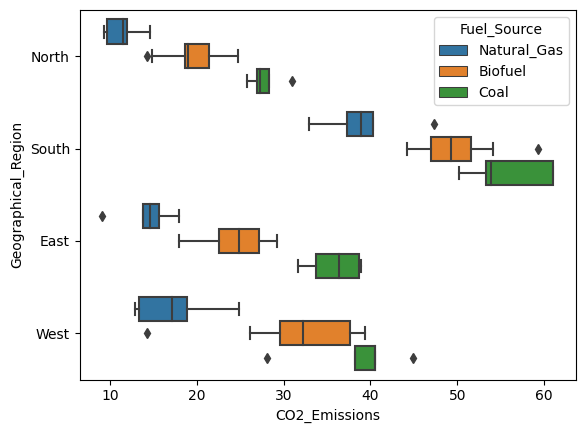

In [6]:
# creating a boxplot
sns.boxplot(x = 'CO2_Emissions', y = 'Geographical_Region',hue = 'Fuel_Source', data = data)

In [7]:
# combination of region and fuel source with highest median CO2 emissions
highest_co2 = data.nlargest(1, 'CO2_Emissions')
highest_co2_region = 'South'
highest_co2_source = 'Coal'

In [8]:
# effect of fuel source and region on CO2 emissions
# the main goal of this code is to apply the one-way ANOVA test (f_oneway()) within each geographical region to see if the CO₂ emissions differ significantly across different fuel sources.
test_results = data.groupby('Geographical_Region').apply(
    lambda x: f_oneway(
        x[x['Fuel_Source'] == 'Natural_Gas']['CO2_Emissions'],
        x[x['Fuel_Source'] == 'Biofuel']['CO2_Emissions'],
        x[x['Fuel_Source'] == 'Coal']['CO2_Emissions']
    )
)
# these three groups are passed into f_oneway(), which performs an ANOVA test to check if the mean CO₂ emissions differ significantly between them.
print('test results:', test_results)

test results: Geographical_Region
East        (50.4975764792117, 7.046450528767474e-08)
North    (45.722317645356284, 1.4439335761931932e-07)
South     (15.29098339477534, 0.00015869217797857807)
West     (12.949717442117826, 0.00038280488933885705)
dtype: object


<ipython-input-8-419fa749649b>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_results = data.groupby('Geographical_Region').apply(


In [9]:
# p_value < 0.05
if any(result.pvalue <0.05 for result in test_results):
    bonferroni_p_values = []
    
# pairwise comparisons for bonferroni correction
for zone in ['North', 'South', 'East', 'West']:
    fuels = ['Natural_Gas', 'Biofuel', 'Coal']
    comparisons = [(fuels[i], fuels[j]) for i in range(len(fuels)) for j in range(i+1, len(fuels))]
    
    for fuel1, fuel2 in comparisons:
        group1 = data[(data['Geographical_Region'] == zone) & (data['Fuel_Source'] == fuel1)]['CO2_Emissions']
        group2 = data[(data['Geographical_Region'] == zone) & (data['Fuel_Source'] == fuel2)]['CO2_Emissions']
        _, p_val = ttest_ind(group1, group2)
        bonferroni_p_values.append(p_val)

    # Apply Bonferroni correction for multiple comparisons
    diff_results = multipletests(bonferroni_p_values, alpha=0.05, method='bonferroni')

print("Bonferroni Corrected P-values:", diff_results[1])

Bonferroni Corrected P-values: [2.97842303e-03 1.60405848e-05 1.51381089e-03 1.95958890e-02
 1.04206412e-02 3.71506293e-01 1.17998627e-03 6.31245443e-05
 6.41264547e-04 2.69611996e-02 4.30884019e-03 1.00000000e+00]
